<a href="https://colab.research.google.com/github/sunmarknatecom/01_markcv/blob/master/step13_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PET/CT영상에서의 비조영CT 분절화**

* STEP 1 : BODY EXTRACTION

* STEP 2 : L3 VERTEBRAL BODY EXTRACTION

* STEP 3 : ABDOMEN SPACE SEGMENTATION

* STEP 4 : ABDOMINAL MUSCLE, VAT, SAT SEGMENTATION


# **코딩 규칙**

> 문자 인용은 C, C++의 규정을 따른다

> 문자 인용은 '' 를 사용: ex) 'a'

> 문자열 인용은 ""를 사용: ex) "ab"

> 변수명은 문자갯수가 4 조합

# 환경설정: 구글드라이브 연결, 모듈과 패키지 설치

## 구글 드라이브 설치가 안 되었을 경우 실행

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

In [1]:
!pip install pydicom pynrrd

# DATA PREPROCESSING
from glob import glob
import numpy as np
import pydicom, cv2, os, copy, shutil
from pydicom.pixel_data_handlers.util import apply_modality_lut, apply_voi_lut
import matplotlib.pyplot as plt
from PIL import Image
from time import time
import pickle

# DEEP LEARNING MODULES
import tensorflow as tf
from keras import backend as K
from keras.losses import binary_crossentropy
from keras.optimizers import adam_v2

from keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, concatenate
from keras.models import Model
from skimage.metrics import structural_similarity as ssim
from random import randint
from sklearn.model_selection import train_test_split

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 18.9 MB/s 


# 1단계: 데이터 불러오기

## CONFIRM THE GPU

In [2]:
!nvidia-smi

Wed Aug 31 00:18:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
    raise SystemError("GPU device not found")
print("Found GPU at: {}".format(device_name))

Found GPU at: /device:GPU:0


## CREATE THE TRAIN DATA AND LABELS

In [4]:
raw_dcm = []
raw_msk = []

with open("/content/drive/MyDrive/segmentation/input_data/sag_input/result_dcm.pkl","rb") as fr:
    raw_dcm = pickle.load(fr)

with open("/content/drive/MyDrive/segmentation/input_data/sag_input/result_msk.pkl","rb") as fr2:
    raw_msk = pickle.load(fr2)

In [5]:
raw_dcm = np.array(raw_dcm)
raw_msk = np.array(raw_msk)

In [6]:
print(np.shape(raw_dcm))
print(np.shape(raw_msk))

(682, 512, 256)
(682, 512, 256)


In [7]:
train_imgs, valid_imgs,train_msks,valid_msks = train_test_split(raw_dcm, raw_msk, test_size=0.2, shuffle=True, random_state=34)

In [11]:
print(np.unique(train_msks))
print(np.shape(train_imgs))
print(np.shape(train_msks))
print(np.shape(valid_imgs))
print(np.shape(valid_msks))


[0. 1.]
(545, 512, 256)
(545, 512, 256)
(137, 512, 256)
(137, 512, 256)


In [ ]:
train_imgs = np.load("/content/drive/MyDrive/segmentation/input_data/train_imgs_A.npy")
train_msks = np.load("/content/drive/MyDrive/segmentation/input_data/train_msks_A.npy")
valid_imgs = np.load("/content/drive/MyDrive/segmentation/input_data/valid_imgs_A.npy")
valid_msks = np.load("/content/drive/MyDrive/segmentation/input_data/valid_msks_A.npy")

In [ ]:
# train_dataset = tf.data.Dataset.from_tensor_slices((train_imgs, train_msks))
# test_dataset = tf.data.Dataset.from_tensor_slices((valid_imgs, valid_msks))

## CONFIRM THE TRAIN DATA ND LABELS

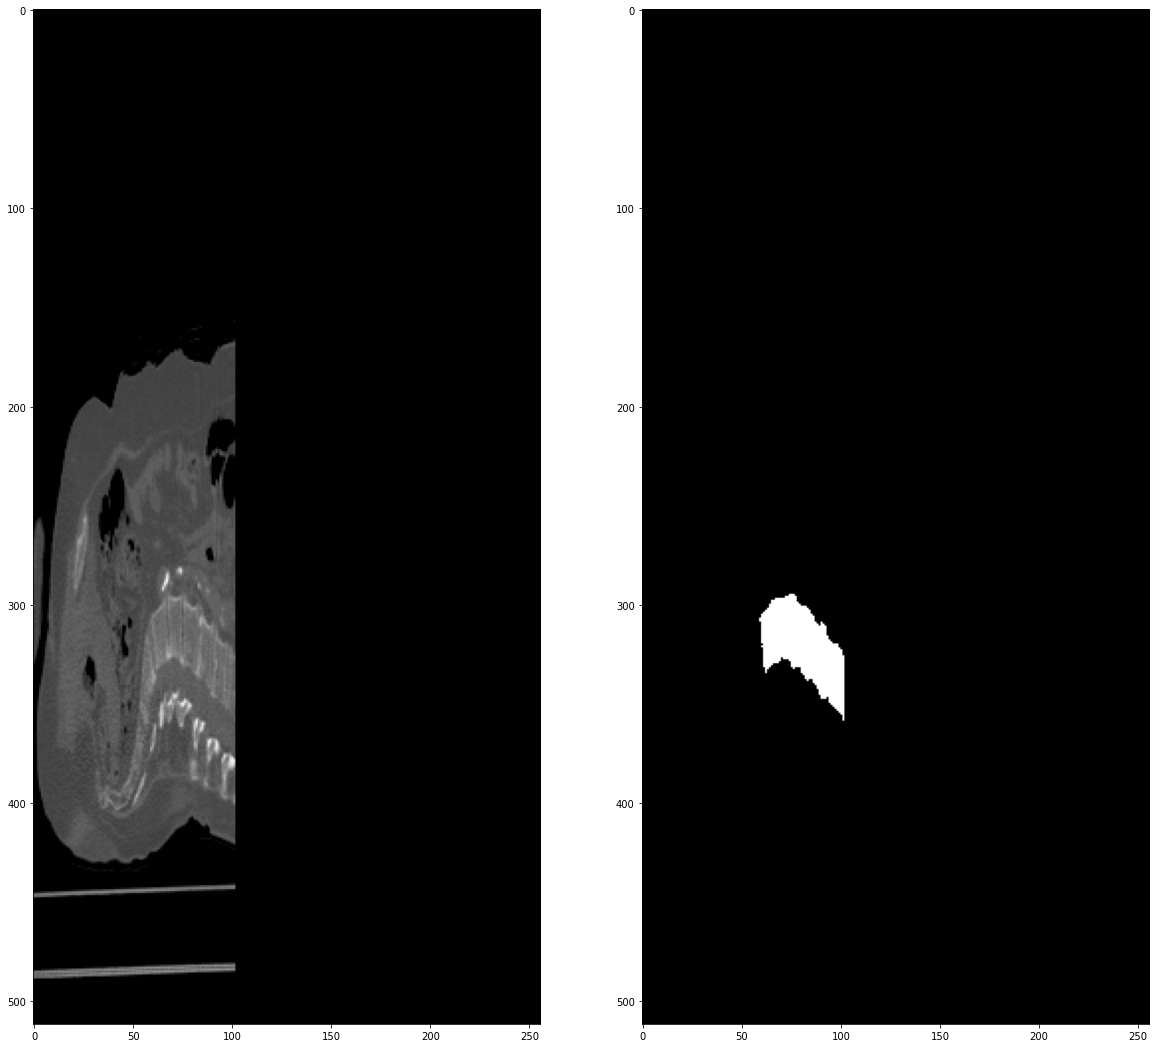

In [12]:
%matplotlib inline

# rand_num = randint(1,len(train_imgs))
rand_num = 300

fig = plt.figure(0, figsize=(20, 20))
fig.add_subplot(1, 2, 1)
plt.imshow(train_imgs[rand_num], cmap='gray')
fig.add_subplot(1, 2, 2)
plt.imshow(np.squeeze(train_msks[rand_num]), cmap='gray')

# 2단계: 딥러닝(Tensorflow)

## CONSTRUCT THE MODEL (U_NET)

In [13]:
del model

NameError: ignored

In [14]:
inputs = Input((512, 256, 1))
bnorm1 = BatchNormalization()(inputs)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(bnorm1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

model = Model(inputs=[inputs], outputs=[conv10])

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 256, 1)  4          ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 512, 256, 32  320         ['batch_normalization[0][0]']    
                                )                                                             

## CUSTOM OBJECTS

In [16]:
beta = 0.25
alpha = 0.25
gamma = 2
epsilon = 1e-5
smooth = 1


class Semantic_loss_functions(object):
    def __init__(self):
        print ("semantic loss functions initialized")

    def dice_coef(self, y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

    def sensitivity(self, y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        return true_positives / (possible_positives + K.epsilon())

    def specificity(self, y_true, y_pred):
        true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
        possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
        return true_negatives / (possible_negatives + K.epsilon())

    def convert_to_logits(self, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        return tf.math.log(y_pred / (1 - y_pred))

    def weighted_cross_entropyloss(self, y_true, y_pred):
        y_pred = self.convert_to_logits(y_pred)
        pos_weight = beta / (1 - beta)
        loss = tf.nn.weighted_cross_entropy_with_logits(logits=y_pred, targets=y_true, pos_weight=pos_weight)
        return tf.reduce_mean(loss)

    def focal_loss_with_logits(self, logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b

    def focal_loss(self, y_true, y_pred):
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        logits = tf.math.log(y_pred / (1 - y_pred))
        loss = self.focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)
        return tf.reduce_mean(loss)

    def depth_softmax(self, matrix):
        sigmoid = lambda x: 1 / (1 + K.exp(-x))
        sigmoided_matrix = sigmoid(matrix)
        softmax_matrix = sigmoided_matrix / K.sum(sigmoided_matrix, axis=0)
        return softmax_matrix

    def generalized_dice_coefficient(self, y_true, y_pred):
        smooth = 1.
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        return score

    def dice_loss(self, y_true, y_pred):
        loss = 1 - self.generalized_dice_coefficient(y_true, y_pred)
        return loss

    def bce_dice_loss(self, y_true, y_pred):
        loss = binary_crossentropy(y_true, y_pred) + self.dice_loss(y_true, y_pred)
        return loss / 2.0

    def confusion(self, y_true, y_pred):
        smooth = 1
        y_pred_pos = K.clip(y_pred, 0, 1)
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.clip(y_true, 0, 1)
        y_neg = 1 - y_pos
        tp = K.sum(y_pos * y_pred_pos)
        fp = K.sum(y_neg * y_pred_pos)
        fn = K.sum(y_pos * y_pred_neg)
        prec = (tp + smooth) / (tp + fp + smooth)
        recall = (tp + smooth) / (tp + fn + smooth)
        return prec, recall

    def true_positive(self, y_true, y_pred):
        smooth = 1
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pos = K.round(K.clip(y_true, 0, 1))
        tp = (K.sum(y_pos * y_pred_pos) + smooth) / (K.sum(y_pos) + smooth)
        return tp

    def true_negative(self, y_true, y_pred):
        smooth = 1
        y_pred_pos = K.round(K.clip(y_pred, 0, 1))
        y_pred_neg = 1 - y_pred_pos
        y_pos = K.round(K.clip(y_true, 0, 1))
        y_neg = 1 - y_pos
        tn = (K.sum(y_neg * y_pred_neg) + smooth) / (K.sum(y_neg) + smooth)
        return tn

    def tversky_index(self, y_true, y_pred):
        y_true_pos = K.flatten(y_true)
        y_pred_pos = K.flatten(y_pred)
        true_pos = K.sum(y_true_pos * y_pred_pos)
        false_neg = K.sum(y_true_pos * (1 - y_pred_pos))
        false_pos = K.sum((1 - y_true_pos) * y_pred_pos)
        alpha = 0.7
        return (true_pos + smooth) / (true_pos + alpha * false_neg + (1 - alpha) * false_pos + smooth)

    def tversky_loss(self, y_true, y_pred):
        return 1 - self.tversky_index(y_true, y_pred)

    def focal_tversky(self, y_true, y_pred):
        pt_1 = self.tversky_index(y_true, y_pred)
        gamma = 0.75
        return K.pow((1 - pt_1), gamma)

    def log_cosh_dice_loss(self, y_true, y_pred):
        x = self.dice_loss(y_true, y_pred)
        return tf.math.log((tf.exp(x) + tf.exp(-x)) / 2.0)

In [17]:
# Reference
# https://www.sciencedirect.com/science/article/pii/S2665963821000269
# https://github.com/SoftwareImpacts/SIMPAC-2021-46

import tensorflow as tf
import keras.backend as K
from keras.losses import binary_crossentropy

beta = 0.25
alpha = 0.25
gamma = 2
epsilon = 1e-5
smooth = 1

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) + K.epsilon())

def generalized_dice_coefficient(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - generalized_dice_coefficient(y_true, y_pred)
    return loss

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss / 2.0

## COMPILE

In [19]:
initial_learning_rate = 1e-4

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath="mymodel_{epoch}.h5",
    save_best_only=True,
    monitor='val_loss',
    verbose=1)]

In [20]:
model.compile(adam_v2.Adam(learning_rate=lr_schedule), bce_dice_loss, metrics=[binary_crossentropy, generalized_dice_coefficient])

## TRAIN(FIT)

In [21]:
start = time()
model.fit(train_imgs, train_msks, batch_size=20, epochs=100, callbacks=callbacks, validation_data=(valid_imgs, valid_msks))
end = time()
et = end - start
print("Elapsed time: %02d hour %02d min %02d sec"%(int(et//3600),int((et%3600)//60), int((et%3600)%60)))

Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 0.8003 - binary_crossentropy: 0.6317 - generalized_dice_coefficient: 0.0308
Epoch 1: val_loss improved from inf to 0.77406, saving model to mymodel_1.h5
28/28 [==============================] - 54s 1s/step - loss: 0.8003 - binary_crossentropy: 0.6317 - generalized_dice_coefficient: 0.0308 - val_loss: 0.7741 - val_binary_crossentropy: 0.5748 - val_generalized_dice_coefficient: 0.0266
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 0.5449 - binary_crossentropy: 0.1389 - generalized_dice_coefficient: 0.0532
Epoch 2: val_loss improved from 0.77406 to 0.49290, saving model to mymodel_2.h5
28/28 [==============================] - 23s 835ms/step - loss: 0.5449 - binary_crossentropy: 0.1389 - generalized_dice_coefficient: 0.0532 - val_loss: 0.4929 - val_binary_crossentropy: 0.1076 - val_generalized_dice_coefficient: 0.1217
Epoch 3/100
28/28 [==============================] - ETA: 0s - loss: 0.3715 - binar

## SAVE THE TRAINED MODEL

In [ ]:
print(np.shape(train_imgs), np.shape(train_msks), np.shape(valid_imgs), np.shape(valid_msks))

(1800, 512, 512) (1800, 512, 512, 1) (499, 512, 512) (499, 512, 512, 1)


In [ ]:
plt_train_msks = np.squeeze(train_msks)
plt_valid_msks = np.squeeze(valid_msks)

In [ ]:
np.shape(plt_train_msks)

(1800, 512, 512)

In [ ]:
np.max(train_imgs)

1.0

In [ ]:
for i in range(499):
    out_img = np.hstack([valid_imgs[i], plt_valid_msks[i]])
    plt.imshow(out_img)
    plt.title(str(i))
    plt.show()

In [23]:
model.save("/content/drive/MyDrive/segmentation/result/sag_result/my_model_sag_A.h5")

## MODEL VIEW

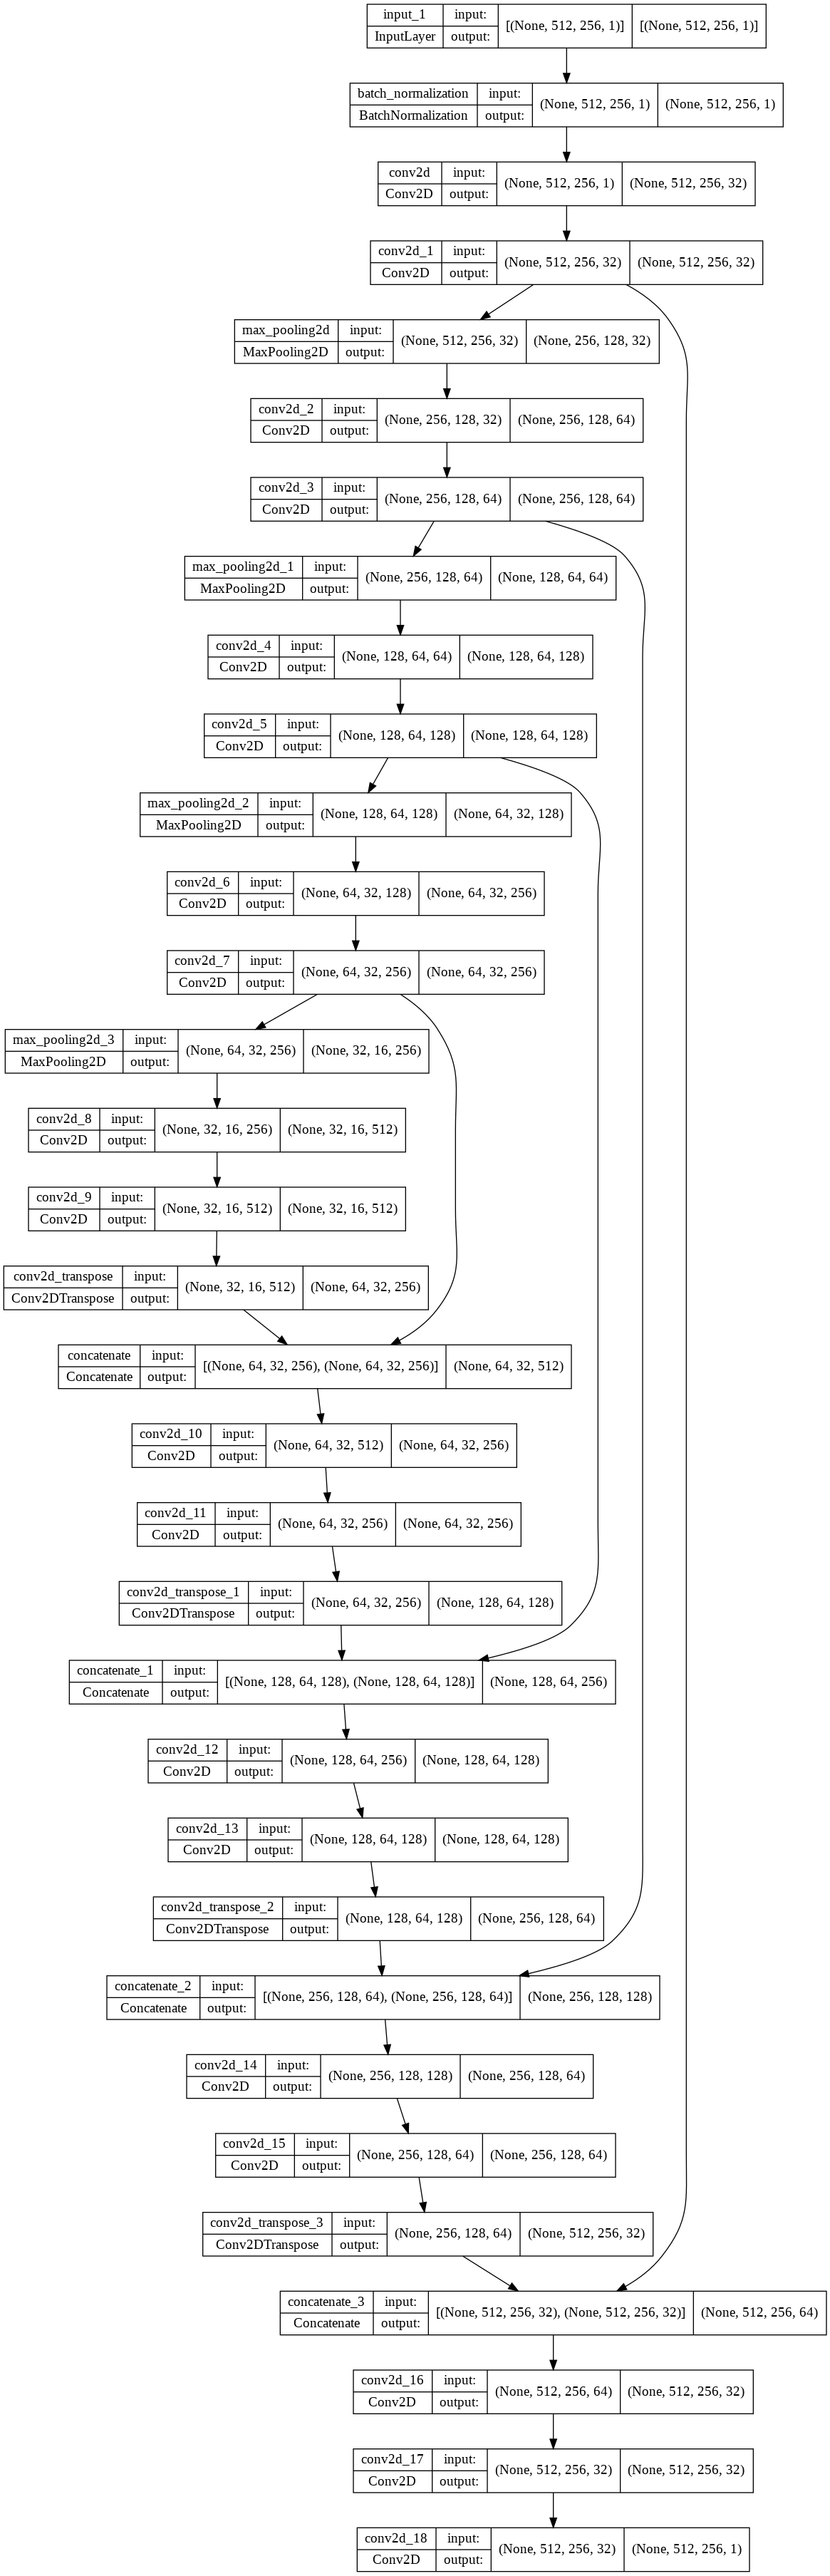

In [24]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
print(model.history.history)

{'loss': [0.2760511636734009, 0.045208461582660675, 0.02681676298379898, 0.024399250745773315, 0.020373038947582245, 0.01962091028690338, 0.01861611194908619, 0.017897993326187134, 0.017772195860743523, 0.016749806702136993, 0.01619580201804638, 0.01532869040966034, 0.01503298431634903, 0.014472383074462414, 0.013965938240289688, 0.013206853531301022, 0.012995216995477676, 0.012446649372577667, 0.012836665846407413, 0.012341774068772793, 0.012121922336518764, 0.01060856506228447, 0.01093060802668333, 0.010937166400253773, 0.010427482426166534, 0.011442102491855621, 0.009933235123753548, 0.009025226347148418, 0.009410574100911617, 0.009464217349886894, 0.009608209133148193, 0.00900142453610897, 0.00860012136399746, 0.008022245019674301, 0.008381111547350883, 0.007782698608934879, 0.008907848037779331, 0.0077085006050765514, 0.007347005419433117, 0.007292516063898802, 0.006934419274330139, 0.0074586714617908, 0.007213683798909187, 0.007053827401250601, 0.006631200201809406, 0.00692124525

In [ ]:
model.history.history.keys()

dict_keys(['loss', 'binary_crossentropy', 'generalized_dice_coefficient', 'val_loss', 'val_binary_crossentropy', 'val_generalized_dice_coefficient'])

In [25]:
loss = model.history.history["loss"]
val_loss = model.history.history['val_loss']

In [26]:
bce = model.history.history["binary_crossentropy"]
val_bce = model.history.history["val_binary_crossentropy"]

In [27]:
GDC = model.history.history["generalized_dice_coefficient"]
val_GDC = model.history.history["val_generalized_dice_coefficient"]

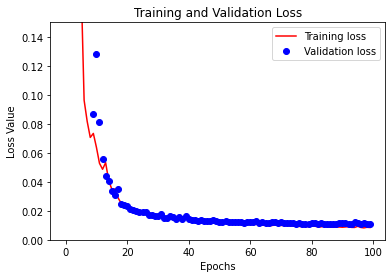

In [28]:
epochs = range(100)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.ylim([0, 0.15])
plt.legend()
plt.show()

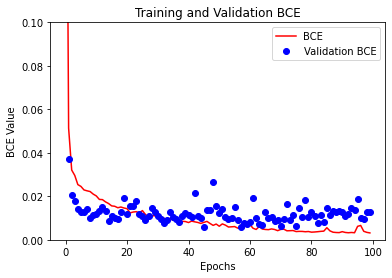

In [ ]:
epochs = range(100)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(epochs, bce, 'r', label='BCE')
plt.plot(epochs, val_bce, 'bo', label='Validation BCE')
plt.title('Training and Validation BCE')
plt.xlabel('Epochs')
plt.ylabel('BCE Value')
plt.ylim([0, 0.1])
plt.legend()
plt.show()

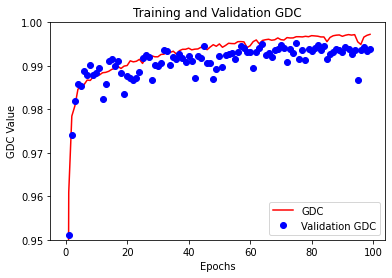

In [ ]:
epochs = range(100)

import matplotlib.pyplot as plt

plt.figure()
plt.plot(epochs, GDC, 'r', label='GDC')
plt.plot(epochs, val_GDC, 'bo', label='Validation GDC')
plt.title('Training and Validation GDC')
plt.xlabel('Epochs')
plt.ylabel('GDC Value')
plt.ylim([0.950, 1])
plt.legend()
plt.show()

In [ ]:
train_imgs[1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
train_imgs[1].max()

1.0

In [ ]:
train_imgs[1].min()

0.0

In [ ]:
type(train_imgs[1])

numpy.ndarray

## LOAD THE SAVED MODEL

In [ ]:
new_model = tf.keras.models.load_model("/content/drive/MyDrive/segmentation/save_model/my_model_A.h5",custom_objects={'bce_dice_loss': bce_dice_loss,'generalized_dice_coefficient': generalized_dice_coefficient} )

In [ ]:
dir(new_model)

In [ ]:
new_model.variables

In [ ]:
model.variables[10]

In [ ]:
a = new_model.variables[10]